## Mathematical Aspects of Machine Learning: Exercise Sheet 3
Luzie Helfmann and Johannes von Lindheim

### Exercise 3 (a)

Define
\begin{align}
\phi: \mathcal{X} & \to \mathcal{H} \\
x & \mapsto k(x, \cdot).\\
\end{align}
Then the points in a dataset may not be linearly seperable, but the $\phi(x) = k(x, \cdot)$, which live in a much higher dimensional space, may be (or at least "better"). We may therefore try something very naïve: For any test point $\tilde{x}$, we just check, whether its image in the feature space $\phi(\tilde{x}) \in \mathcal{H}$ points more into the direction of
\begin{align}
\mu^+ = \frac{1}{m}\sum_{i=1}^m k(x_i^+, \cdot) = \frac{1}{m}\sum_{i=1}^m \phi(x_i^+)  \quad\text{or}\quad \mu^- = \frac{1}{m'}\sum_{i=1}^{m'} k(x_i^-, \cdot) = \frac{1}{m'}\sum_{i=1}^{m'} \phi(x_i^-)
\end{align}
i.e. if $\langle \phi(\tilde{x}), \mu^+ \rangle$ or $\langle \phi(\tilde{x}), \mu^- \rangle$ is larger.

The intuition behind this goes as follows. If we employ the Gaussian kernel
\begin{align}
k(x, y) = \exp(-\sigma||x-y||_2^2)
\end{align}
then e.g. $\mu^+ = \sum_{i=1}^m \exp(-\sigma||x_i^+-\cdot||_2^2)$ can be seen as a "cloud" around the points with plus-labels, which has high values, if a point lies close to that cloud. Therefore, the scalar product $\langle \phi(\tilde{x}), \mu^+ \rangle_\mathcal{H} = \langle k(\tilde{x}, \cdot), \mu^+ \rangle_\mathcal{H} = k(\tilde{x}, \sum_{i=1}^m x_i^+)$ is a measure, how well the point $\tilde{x}$ sits in the cloud of points with plus-labels (or minus-labels, respectively), since $\exp(-\sigma||\tilde{x}-\cdot||_2^2)$ can be seen as a cloud around $\tilde{x}$.

$\sigma$ is a parameter, which makes the clouds narrower or wider with greater or smaller values.

For any point $\tilde{x}$, we may therefore just check, whether the function
\begin{align}
z(x) := \sum_{i=1}^m k(x_i^+, x) - \sum_{i=1}^{m'} k(x_i^-, \cdot)
\end{align}
with $k(x, y) = \exp(-\sigma||x-y||_2^2)$ is smaller or greater than zero.

### Exercise 3 (b)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn.datasets as dsets
#from random import sample
#import seaborn as sns
%matplotlib inline

In [2]:
def classifier(x, xplus, xminus, sigma):
    '''
    Calculates the value of the classifier function: If smaller than zero, a minus-label is assigned, a plus-label otherwise.
    input:  
            x: argument of the classifier function
            xplus: nparray, training data with plus labels
            xminus: nparray, training data with minus labels
            sigma: scalar parameter, how widespread the influence of training points is (wide for small values). Has to be > 0.
    output:
            scalar alue of the classifier function
    '''
    
    return(np.exp([-sigma * pow(np.linalg.norm(x - xiplus, 2), 2) for xiplus in xplus]).sum() 
           - np.exp([-sigma * pow(np.linalg.norm(x - ximinus, 2), 2) for ximinus in xminus]).sum())

In [3]:
def format_plot(fig, ax, xmin, ymin, xmax, ymax):
    '''
    Formats a figure and axis object to equal aspects, assigns axis labels.
    '''
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_aspect('equal')
    fig.tight_layout()
    

In [4]:
def format_plot(fig, ax):
    '''
    Formats a figure and axis object to equal aspects, assigns axis labels.
    '''
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_aspect('equal')
    fig.tight_layout()

In [5]:
def plot_classifier(xplus, xminus, sigma):
    '''
    Plots the data points and a colormap for the classifier function.
    input:  
            xplus: nparray, training data with plus labels
            xminus: nparray, training data with minus labels
            sigma: scalar parameter, how widespread the influence of training points is (wide for small values). Has to be > 0.
    '''
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.scatter(xplus[:, 0], xplus[:, 1], c='white', edgecolors='black')
    plt.scatter(xminus[:, 0], xminus[:, 1], c='black')
    format_plot(fig, ax)
    
    # Calculate classifier function values on a mesh
    margin = 0.5
    h = 0.1
    sigma = 1.0
    xmin = data[0][:, 0].min() - margin
    xmax = data[0][:, 0].max() + margin
    ymin = data[0][:, 1].min() - margin
    ymax = data[0][:, 1].max() + margin
    xmesh = np.arange(xmin, xmax, h)
    ymesh = np.arange(ymin, ymax, h)
    xx, yy = np.meshgrid(xmesh, ymesh)
    zz = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([classifier(pt, xplus, xminus, sigma) for pt in zz]).reshape(len(ymesh), len(xmesh))
    
    # Create plot and colorbar
    im = plt.imshow(Z, interpolation='bilinear', origin='lower', cmap=cm.RdBu, extent=(xmin, xmax, ymin, ymax))
    CBI = plt.colorbar(im, orientation='vertical', shrink=0.4)

In [6]:
def nfold_crossval(n, xplus, xminus, sigma):
    '''
    Performs an n-fold cross-validation to check, how many points are classified wrong.
    input:  
            n: in how many chunks the dataset is split
            xplus: nparray, training data with plus labels
            xminus: nparray, training data with minus labels
            sigma: scalar parameter, how widespread the influence of training points is (wide for small values). Has to be > 0.
    '''

    # Split data into nfold almost equal sized, random parts
    xplus_shuffled = np.random.permutation(xplus)
    xplus_chunks = np.array([xplus_shuffled[i::n] for i in range(n)])
    xminus_shuffled = np.random.permutation(xminus)
    xminus_chunks = np.array([xminus_shuffled[i::n] for i in range(n)])
    
    # Leave one of the chunks out, train model on the rest and count, how many are classified wrong
    num_wrong = 0
    for i in range(n):
        num_wrong += sum([classifier(xplus_chunks[i, j, :], np.delete(xplus_chunks, i, 0), np.delete(xminus_chunks, i, 0), sigma) <= 0 for j in range(xplus_chunks[i, :, :].shape[0])]
                        ) + sum([classifier(xminus_chunks[i, j, :], np.delete(xplus_chunks, i, 0), np.delete(xminus_chunks, i, 0), sigma) >= 0  for j in range(xminus_chunks[i, :, :].shape[0])])
    return (num_wrong / (xplus.shape[0] + xminus.shape[0]))

#### Moons dataset

Cross-validation error: 0.21


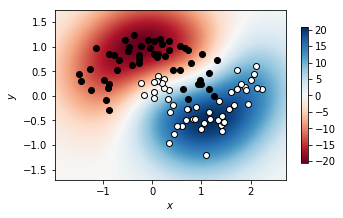

In [7]:
# Create dataset
data = dsets.make_moons(n_samples=100, shuffle=True, noise=0.2)
xminus, xplus = data[0][data[1] == 0], data[0][data[1] == 1]

# Plot datapoints and classifier function
sigma = 1.0
plot_classifier(xplus, xminus, sigma=sigma)

# Print cross-validation error
print("Cross-validation error: %.2f" % nfold_crossval(n=5, xplus=xplus, xminus=xminus, sigma=sigma))

#### Classification dataset

Cross-validation error: 0.12


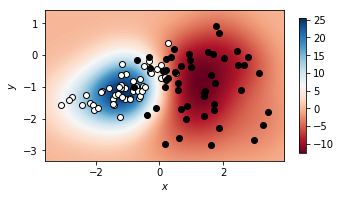

In [11]:
# Create dataset
data = dsets.make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2, 
                                 n_clusters_per_class=1)
xminus, xplus = data[0][data[1] == 0], data[0][data[1] == 1]

# Plot datapoints and classifier function
sigma = 1.0
plot_classifier(xplus, xminus, sigma=sigma)

# Print cross-validation error
print("Cross-validation error: %.2f" % nfold_crossval(n=5, xplus=xplus, xminus=xminus, sigma=sigma))

#### Circles dataset

Cross-validation error: 0.45


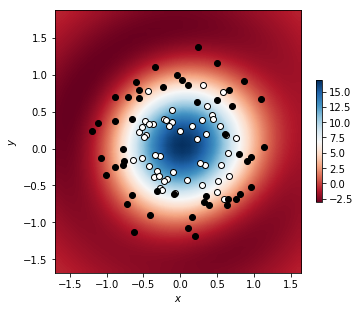

In [9]:
# Create dataset
data = dsets.make_circles(n_samples=100, shuffle=True, noise=0.2, factor=0.5)
xminus, xplus = data[0][data[1] == 0], data[0][data[1] == 1]

# Plot datapoints and classifier function
sigma = 1.0
plot_classifier(xplus, xminus, sigma=sigma)

# Print cross-validation error
print("Cross-validation error: %.2f" % nfold_crossval(n=5, xplus=xplus, xminus=xminus, sigma=sigma))

The algorithm performs more or less well in the first two cases but very bad in the last case: It is hardly better than random classification. The reason for this is that the level line of zero is in the wrong place here: It should have been better placed exactly between the two circles (where the white line is). It is not placed there, since the white points lie in the center and therefore have influence over more relevant regions than the black points on the outside.